<a href="https://colab.research.google.com/github/amelsheikh/PathMNIST-Classification/blob/main/653_PathMNIST_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install medmnist
%pip install tensorflow keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.5.0-py2.py3-none-any.whl size=116933 sha256=20fbb174d588afdd285cb23ddd0960fb17eed5c1d1338b0b1b44b90eec69b2d8
  Stored in directory: /root/.cache/pip/wheels/90/d4/f7/9404e5db0116bd4d43e5666eaa3e70ab53723e1e3ea40c9a95
Successfully built fire


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Dataset MedMNIST - PathMNIST
PathMNIST
The PathMNIST is based on a prior study16,17 for predicting survival from colorectal cancer histology slides, providing a dataset (NCT-CRC-HE-100K) of 100,000 non-overlapping image patches from hematoxylin & eosin stained histological images, and a test dataset (CRC-VAL-HE-7K) of 7,180 image patches from a different clinical center. The dataset is comprised of 9 types of tissues, resulting in a multi-class classification task. We resize the source images of 3 × 224 × 224 into 3 × 28 × 28, and split NCT-CRC-HE-100K into training and validation set with a ratio of 9:1. The CRC-VAL-HE-7K is treated as the test set.
(NCT-CRC-HE-100K) dataset:
Has nine tissue classes: Adipose (ADI), background (BACK), debris (DEB), lymphocytes (LYM), mucus (MUC), smooth muscle (MUS), normal colon mucosa (NORM), cancer-associated stroma (STR), colorectal adenocarcinoma epithelium (TUM)
<br>Reference: https://paperswithcode.com/dataset/nct-crc-he-100k

In [2]:
# Dataset retrieval
import medmnist
from medmnist.dataset import PathMNIST

# retrieve the dataset in image format for further analysis
pathMnist_train = PathMNIST(split='train', download=True)
pathMnist_test = PathMNIST(split='test', download=True)
pathMnist_val = PathMNIST(split='val', download=True)
# format the downloaded images
pathMnist_train.save(folder='MedMNIST/PathMNIST/train/', postfix='png', write_csv=True)
pathMnist_test.save(folder='MedMNIST/PathMNIST/test/', postfix='png', write_csv=True)
pathMnist_val.save(folder='MedMNIST/PathMNIST/val/', postfix='png', write_csv=True)

100%|██████████| 205615438/205615438 [00:10<00:00, 19921184.00it/s]


Using downloaded and verified file: /root/.medmnist/pathmnist.npz
Using downloaded and verified file: /root/.medmnist/pathmnist.npz


100%|██████████| 10004/10004 [00:03<00:00, 3327.96it/s]


In [3]:
# structure the dataset into folders corresponding to classes {example: class_0, class_1}
import os, shutil

train_src_fldr = "MedMNIST/PathMNIST/train/pathmnist/"
test_src_fldr = "MedMNIST/PathMNIST/test/pathmnist/"
val_src_fldr = "MedMNIST/PathMNIST/val/pathmnist/"

# structure training dataset
for file in os.listdir(train_src_fldr):
    # parse the file name to get the class value (suffix)
    class_val = file.split("_")[-1].split(".")[0]
    # prep. destination folder
    dest_fldr = "MedMNIST/PathMNIST/train_structured"+"/class_"+class_val
    # check if it doesn't exist
    if not os.path.exists(dest_fldr):
        os.makedirs(dest_fldr)

    # Copy
    shutil.copy(os.path.join(train_src_fldr, file), dest_fldr)

# structure testing dataset
for file in os.listdir(test_src_fldr):
    # parse the file name to get the class value (suffix)
    class_val = file.split("_")[-1].split(".")[0]
    # prep. destination folder
    dest_fldr = "MedMNIST/PathMNIST/test_structured"+"/class_"+class_val
    # check if it doesn't exist
    if not os.path.exists(dest_fldr):
        os.makedirs(dest_fldr)

    # Copy
    shutil.copy(os.path.join(test_src_fldr, file), dest_fldr)

# structure validation dataset
for file in os.listdir(val_src_fldr):
    # parse the file name to get the class value (suffix)
    class_val = file.split("_")[-1].split(".")[0]
    # prep. destination folder
    dest_fldr = "MedMNIST/PathMNIST/val_structured"+"/class_"+class_val
    # check if it doesn't exist
    if not os.path.exists(dest_fldr):
        os.makedirs(dest_fldr)

    # Copy
    shutil.copy(os.path.join(val_src_fldr, file), dest_fldr)

In [4]:
#import shutil
#shutil.copytree("MedMNIST/", "drive/MyDrive/CPSC653_MedMNIST/", dirs_exist_ok=True)

In [5]:
import tensorflow as tf
from tensorflow import keras
from keras import layers

In [6]:
img_size = (256, 256)
btch_size = 128

train_ds = keras.utils.image_dataset_from_directory("MedMNIST/PathMNIST/train_structured")
test_ds = keras.utils.image_dataset_from_directory("MedMNIST/PathMNIST/test_structured")
val_ds = keras.utils.image_dataset_from_directory("MedMNIST/PathMNIST/val_structured")

Found 89996 files belonging to 9 classes.
Found 7180 files belonging to 9 classes.
Found 10004 files belonging to 9 classes.


### Visualize a sample of the dataset

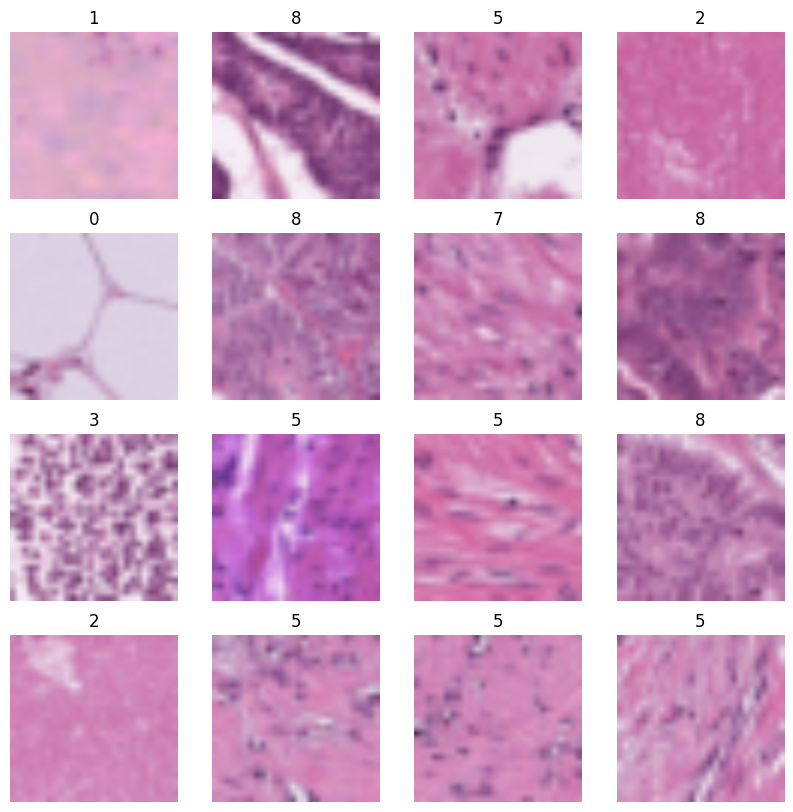

In [ ]:
# Visualize a sample of the training data
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
for images, lables in train_ds.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(lables[i]))
        plt.axis("off")

### Data Augmentation
While it may not be very useful for this dataset. It is normally useful in cases where we don't have many training dataset samples. It is one way to introduce artificial diversity to the current dataset. Data augmentation here can be flipping images horizontally or vertically or applying degrees of rotations. This technique exposes the model to variations of the training samples and reduces overfitting.

In [7]:
# define data augmentation
data_augmentation_layer = keras.Sequential(
    [
        layers.Rescaling(scale=1.0/255, input_shape=img_size+(3,)),
        #layers.RandomFlip('horizontal'),
        #layers.RandomRotation(0.1),
        #layers.RandomZoom(0.2),
        #layers.RandomWidth(0.2),
        #layers.RandomHeight(0.2),
        #layers.RandomContrast(0.2)
    ], name='data_augmentation')

### Build a baseline ConvNet model

Model Input Shape:  (None, 256, 256, 3)
Model Output Shape:  (None, 9)


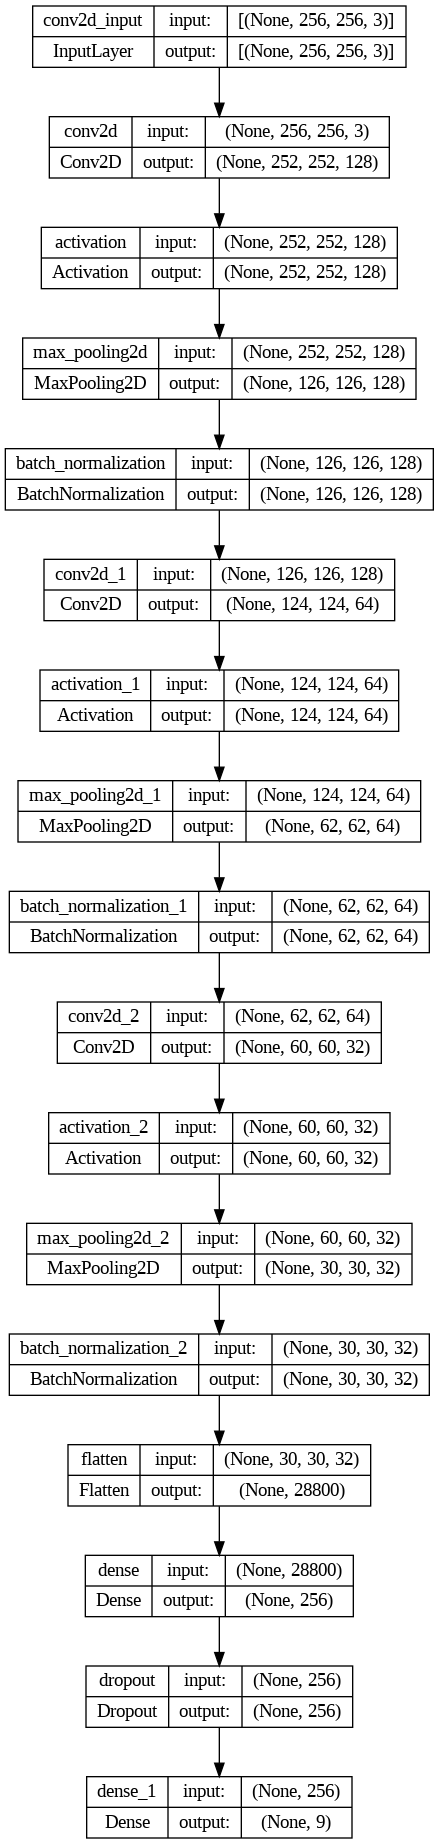

In [8]:
from keras.models import Sequential
from keras.regularizers import l2

def make_model_convNet(input_shape, num_classes):
    model = Sequential([
        layers.Conv2D(filters=128, kernel_size=(5, 5), padding='valid', input_shape=input_shape),
        layers.Activation('relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.BatchNormalization(),

        layers.Conv2D(filters=64, kernel_size=(3, 3), padding='valid', kernel_regularizer=l2(0.00005)),
        layers.Activation('relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.BatchNormalization(),

        layers.Conv2D(filters=32, kernel_size=(3, 3), padding='valid', kernel_regularizer=l2(0.00005)),
        layers.Activation('relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.BatchNormalization(),

        layers.Flatten(),

        layers.Dense(units=256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(units=num_classes, activation='softmax')
    ])
    return model

# define the actual model
model_convNet = make_model_convNet(input_shape=img_size + (3,), num_classes=9)
# for testing
print("Model Input Shape: ", model_convNet.input_shape)
print("Model Output Shape: ", model_convNet.output_shape)


keras.utils.plot_model(model_convNet, show_shapes=True)

### Train the baseline model

In [9]:
epochs = 50
# checkpoint = keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras")
checkpoint = keras.callbacks.ModelCheckpoint('ConvNet-model-{val_accuracy:.3f}.hdf5', monitor='val_accuracy',
                                             verbose=1, save_best_only=True, mode='max')
earlystopping = keras.callbacks.EarlyStopping(monitor="val_loss", mode="min", patience=5, restore_best_weights=True)

callbacks = [checkpoint, earlystopping]
model_convNet.compile(
    optimizer = keras.optimizers.Adam(1e-3),
    loss = "sparse_categorical_crossentropy",
    metrics = ["accuracy"],
)

history_convNet = model_convNet.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/50
2813/2813 [==============================] - ETA: 0s - loss: 2.4551 - accuracy: 0.5867
Epoch 1: val_accuracy improved from -inf to 0.61765, saving model to ConvNet-model-0.618.hdf5
2813/2813 [==============================] - 108s 34ms/step - loss: 2.4551 - accuracy: 0.5867 - val_loss: 1.0667 - val_accuracy: 0.6177
Epoch 2/50


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2811/2813 [============================>.] - ETA: 0s - loss: 0.9573 - accuracy: 0.6695
Epoch 2: val_accuracy did not improve from 0.61765
2813/2813 [==============================] - 94s 33ms/step - loss: 0.9572 - accuracy: 0.6696 - val_loss: 7.4325 - val_accuracy: 0.1229
Epoch 3/50
2811/2813 [============================>.] - ETA: 0s - loss: 0.7940 - accuracy: 0.7277
Epoch 3: val_accuracy did not improve from 0.61765
2813/2813 [==============================] - 94s 33ms/step - loss: 0.7943 - accuracy: 0.7276 - val_loss: 17.1585 - val_accuracy: 0.2451
Epoch 4/50
2811/2813 [============================>.] - ETA: 0s - loss: 0.6932 - accuracy: 0.7680
Epoch 4: val_accuracy did not improve from 0.61765
2813/2813 [==============================] - 94s 33ms/step - loss: 0.6931 - accuracy: 0.7680 - val_loss: 26.5766 - val_accuracy: 0.2822
Epoch 5/50
2811/2813 [============================>.] - ETA: 0s - loss: 0.5995 - accuracy: 0.7998
Epoch 5: val_accuracy did not improve from 0.61765
2813/281

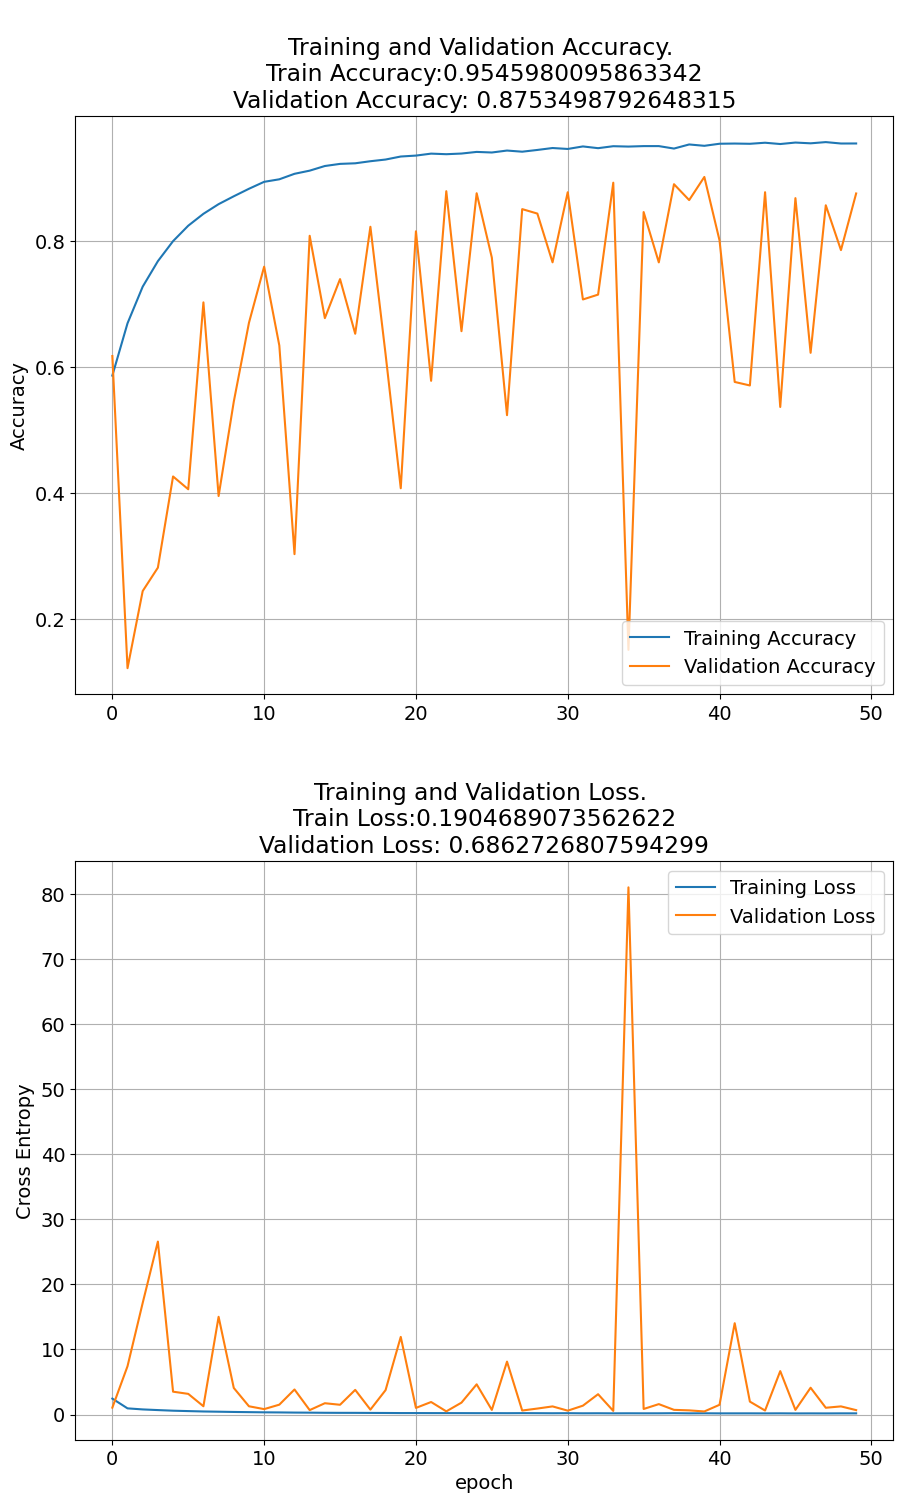

In [11]:
import matplotlib.pyplot as plt

# store results
acc = history_convNet.history['accuracy']
val_acc = history_convNet.history['val_accuracy']
loss = history_convNet.history['loss']
val_loss = history_convNet.history['val_loss']

# plot results
# accuracy
plt.figure(figsize=(10, 16))
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['font.size'] = 14
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.facecolor'] = 'white'
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title(f'\nTraining and Validation Accuracy. \nTrain Accuracy:{str(acc[-1])}\nValidation Accuracy: {str(val_acc[-1])}')

# loss
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title(f'Training and Validation Loss. \nTrain Loss:{str(loss[-1])}\nValidation Loss: {str(val_loss[-1])}')
plt.xlabel('epoch')
plt.tight_layout(pad=3.0)
plt.show()

### Build the model using (Xception network)
Here a small verions of Xception network is bing used. Further work can be done to optimize the architecture using KerasTuner.
<b>Note</b>: the augmentation is added as a layer, followed by rescaling (to optimize the images for neural network models)

Model Input Shape:  (None, 256, 256, 3)
Model Output Shape:  (None, 9)


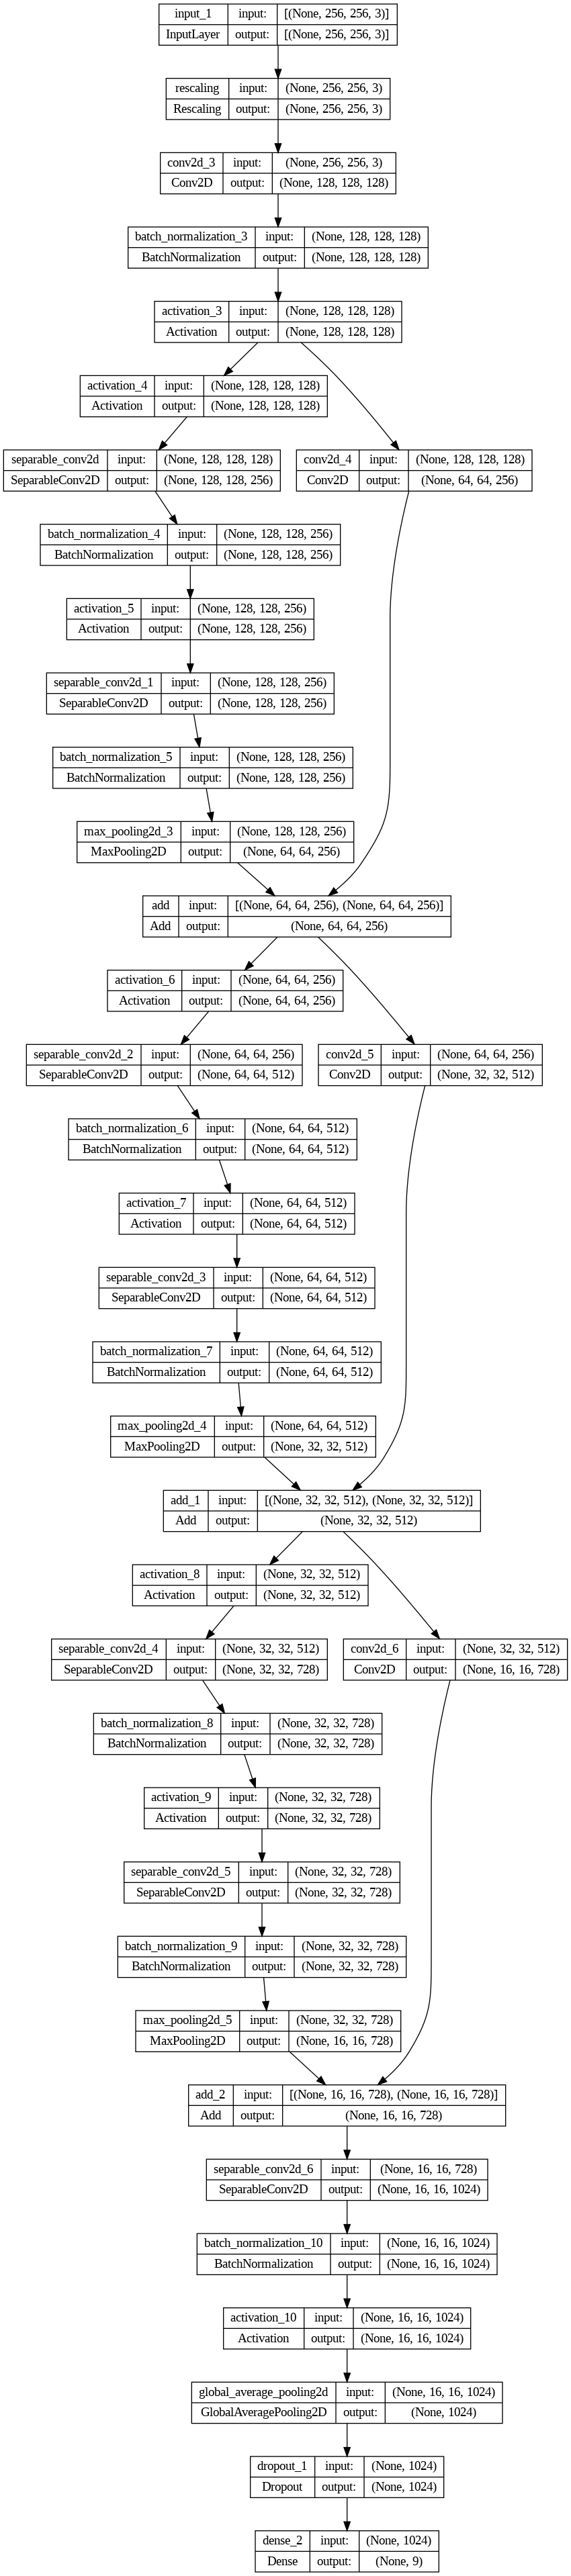

In [ ]:
def make_model_XceptionNet(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # First block
    #x = data_augment(inputs)    # apply data augmentation
    x = layers.Rescaling(1.0 / 255)(inputs)   # apply rescaling
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)  # normalize the input
    x = layers.Activation("relu")(x)

    prev_blck_activation = x    # first residual
    # using default/sample architecture
    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(prev_blck_activation)
        x = layers.add([x, residual])   # add residual
        prev_blck_activation = x    # set aside the next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units=units, activation=activation)(x)
    return keras.Model(inputs, outputs)


# define the actual model
model_XceptionNet = make_model_XceptionNet(input_shape=img_size + (3,), num_classes=9)
# for testing
print("Model Input Shape: ", model_XceptionNet.input_shape)
print("Model Output Shape: ", model_XceptionNet.output_shape)


keras.utils.plot_model(model_XceptionNet, show_shapes=True)


### Train the XceptionNet model

In [ ]:
epochs = 50
# checkpoint = keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras")
checkpoint = keras.callbacks.ModelCheckpoint('Xception-model-{val_accuracy:.3f}.hdf5', monitor='val_accuracy',
                                              verbose=1, save_best_only=True, mode='max')
earlystopping = keras.callbacks.EarlyStopping(monitor="val_loss", mode="min", patience=5, restore_best_weights=True)

callbacks = [checkpoint, earlystopping]
model_XceptionNet.compile(
    optimizer = keras.optimizers.Adam(1e-3),
    loss = "sparse_categorical_crossentropy",
    metrics = ["accuracy"],
)

history_XceptionNet = model_XceptionNet.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/50
2813/2813 [==============================] - ETA: 0s - loss: 0.5082 - accuracy: 0.8199
Epoch 1: val_accuracy improved from -inf to 0.81787, saving model to Xception-model-0.818.hdf5
2813/2813 [==============================] - 540s 184ms/step - loss: 0.5082 - accuracy: 0.8199 - val_loss: 0.6054 - val_accuracy: 0.8179


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/50
2813/2813 [==============================] - ETA: 0s - loss: 0.2213 - accuracy: 0.9251
Epoch 2: val_accuracy did not improve from 0.81787
2813/2813 [==============================] - 518s 184ms/step - loss: 0.2213 - accuracy: 0.9251 - val_loss: 3.1204 - val_accuracy: 0.5023
Epoch 3/50
2813/2813 [==============================] - ETA: 0s - loss: 0.1625 - accuracy: 0.9452
Epoch 3: val_accuracy improved from 0.81787 to 0.89234, saving model to Xception-model-0.892.hdf5
2813/2813 [==============================] - 516s 183ms/step - loss: 0.1625 - accuracy: 0.9452 - val_loss: 0.3824 - val_accuracy: 0.8923
Epoch 4/50
2813/2813 [==============================] - ETA: 0s - loss: 0.1297 - accuracy: 0.9560
Epoch 4: val_accuracy did not improve from 0.89234
2813/2813 [==============================] - 514s 183ms/step - loss: 0.1297 - accuracy: 0.9560 - val_loss: 3.1826 - val_accuracy: 0.6480
Epoch 5/50
2813/2813 [==============================] - ETA: 0s - loss: 0.1104 - accuracy: 0.96

In [ ]:
# store results
acc = history_XceptionNet.history['accuracy']
val_acc = history_XceptionNet.history['val_accuracy']
loss = history_XceptionNet.history['loss']
val_loss = history_XceptionNet.history['val_loss']

# plot results
# accuracy
plt.figure(figsize=(10, 16))
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['font.size'] = 14
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.facecolor'] = 'white'
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title(f'\nTraining and Validation Accuracy. \nTrain Accuracy:{str(acc[-1])}\nValidation Accuracy: {str(val_acc[-1])}')

# loss
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title(f'Training and Validation Loss. \nTrain Loss:{str(loss[-1])}\nValidation Loss: {str(val_loss[-1])}')
plt.xlabel('epoch')
plt.tight_layout(pad=3.0)
plt.show()

#### Load model's weight and evaluate using testing dataset

In [ ]:
#load a model using model weights file
model_XceptionNet.load_weights("Xception-model-0.983.hdf5")
model_XceptionNet.compile(
    optimizer = keras.optimizers.Adam(learning_rate=1e-3),
    loss = "sparse_categorical_crossentropy",
    metrics = ["accuracy"],
)

# evaluate model using the testing dataset
acc_score = model_XceptionNet.evaluate(test_ds)
print(acc_score)
print("Accuracy: {:.4f}%".format(acc_score[1] * 100))
print("Loss: ", acc_score[0])

### Transfer Learning
In this section, the image classification model is trained using multiple pre-trained models

#### Transfer learning - Using VGG16

Model Input Shape:  (None, 256, 256, 3)
Model Output Shape:  (None, 9)


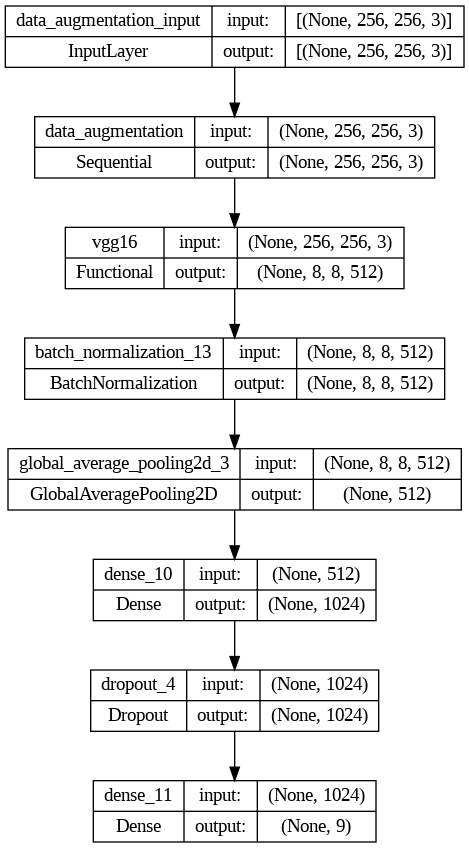

In [21]:
from keras.models import Sequential
from keras.regularizers import l2

def make_model_transferVgg16(input_shape, num_classes):
    # get the base model (VGG16)
    base_model = keras.applications.VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False

    '''
    model = Sequential([
        data_augmentation_layer,
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(1024, activation='relu'),

        layers.Dropout(0.5),
        layers.Dense(units=num_classes, activation='softmax'),
        ])
    '''
    model = Sequential([
        data_augmentation_layer,
        base_model,
        layers.BatchNormalization(),
        layers.GlobalAveragePooling2D(),
        layers.Dense(1024, activation='relu'),
        #layers.Dense(256, activation='relu'),

        layers.Dropout(0.5),
        #layers.Dense(1024, activation='relu'),
        layers.Dense(units=num_classes, activation='softmax'),
        ])

    return model

# define the actual model
model_transferVgg16 = make_model_transferVgg16(input_shape=img_size + (3,), num_classes=9)
# for testing
print("Model Input Shape: ", model_transferVgg16.input_shape)
print("Model Output Shape: ", model_transferVgg16.output_shape)

keras.utils.plot_model(model_transferVgg16, show_shapes=True)

#### Train VGG16 model

In [24]:
epochs = 50

# checkpoint = keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras")
checkpoint = keras.callbacks.ModelCheckpoint('Vgg16-model-{val_accuracy:.3f}.hdf5', monitor='val_accuracy',
                                              verbose=1, save_best_only=True, mode='max')
#earlystopping = keras.callbacks.EarlyStopping(monitor="val_loss", mode="min", patience=10, restore_best_weights=True)

callbacks = [checkpoint,]

model_transferVgg16.compile(
    optimizer = keras.optimizers.Adam(1e-3),
    loss = "sparse_categorical_crossentropy",
    metrics = ["accuracy"],
)

history_vgg16 = model_transferVgg16.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/50
2812/2813 [============================>.] - ETA: 0s - loss: 0.6432 - accuracy: 0.7668
Epoch 1: val_accuracy improved from -inf to 0.83287, saving model to Vgg16-model-0.833.hdf5
2813/2813 [==============================] - 98s 34ms/step - loss: 0.6433 - accuracy: 0.7668 - val_loss: 0.4699 - val_accuracy: 0.8329
Epoch 2/50
2811/2813 [============================>.] - ETA: 0s - loss: 0.5429 - accuracy: 0.8030
Epoch 2: val_accuracy improved from 0.83287 to 0.83906, saving model to Vgg16-model-0.839.hdf5
2813/2813 [==============================] - 97s 34ms/step - loss: 0.5429 - accuracy: 0.8030 - val_loss: 0.4397 - val_accuracy: 0.8391
Epoch 3/50
2811/2813 [============================>.] - ETA: 0s - loss: 0.5037 - accuracy: 0.8169
Epoch 3: val_accuracy improved from 0.83906 to 0.84996, saving model to Vgg16-model-0.850.hdf5
2813/2813 [==============================] - 97s 34ms/step - loss: 0.5037 - accuracy: 0.8169 - val_loss: 0.4181 - val_accuracy: 0.8500
Epoch 4/50
2811/281

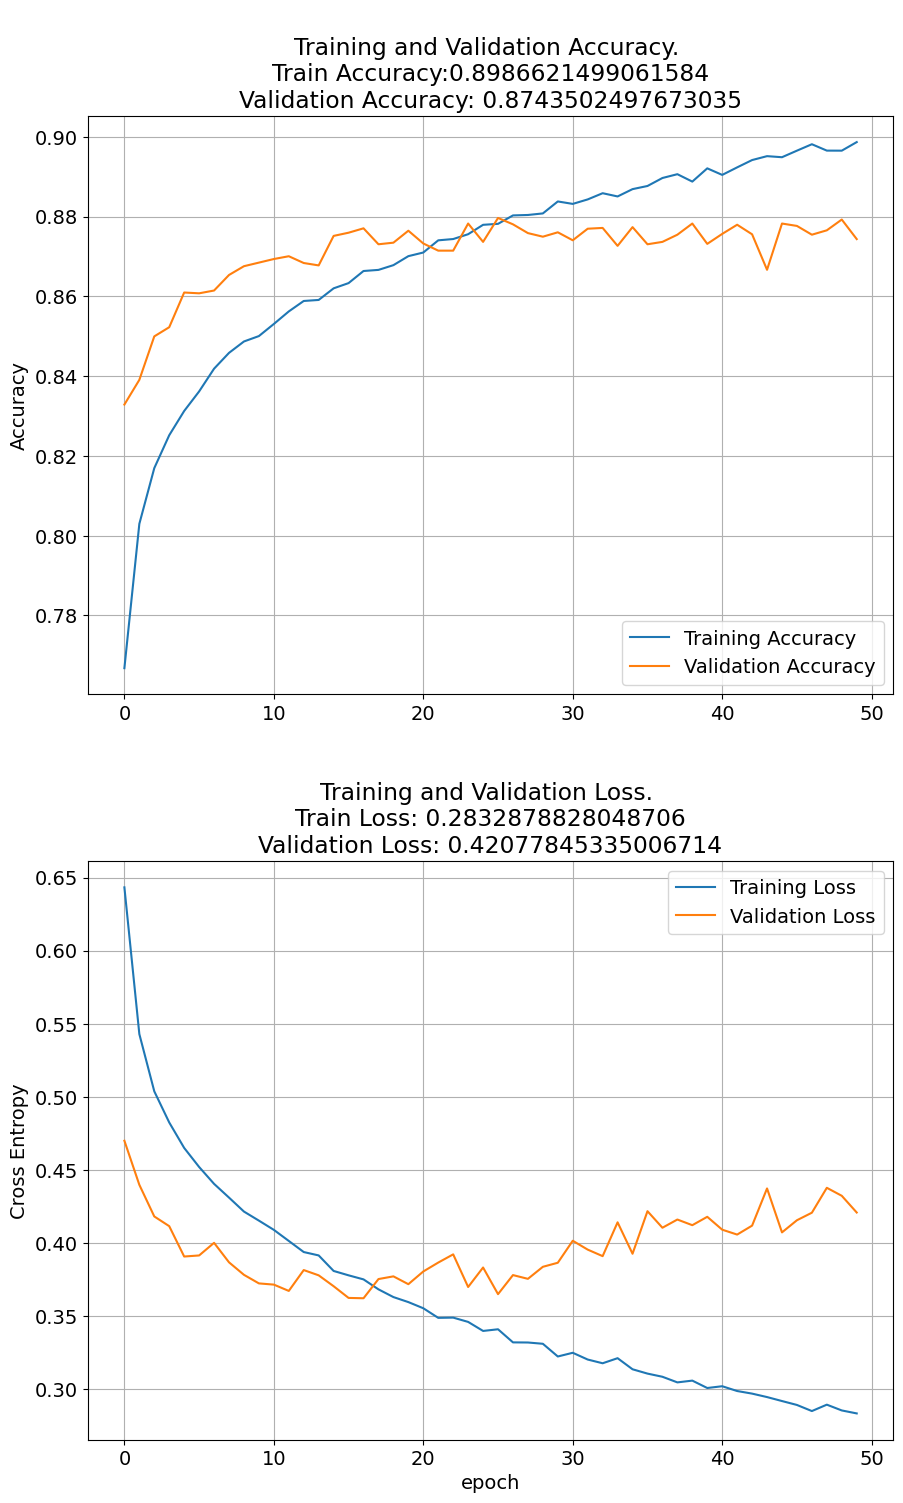

In [25]:
import matplotlib.pyplot as plt

# store results
acc = history_vgg16.history['accuracy']
val_acc = history_vgg16.history['val_accuracy']
loss = history_vgg16.history['loss']
val_loss = history_vgg16.history['val_loss']

# plot results
# accuracy
plt.figure(figsize=(10, 16))
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['font.size'] = 14
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.facecolor'] = 'white'
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title(f'\nTraining and Validation Accuracy. \nTrain Accuracy:{str(acc[-1])}\nValidation Accuracy: {str(val_acc[-1])}')

# loss
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title(f'Training and Validation Loss. \nTrain Loss: {str(loss[-1])}\nValidation Loss: {str(val_loss[-1])}')
plt.xlabel('epoch')
plt.tight_layout(pad=3.0)
plt.show()

In [ ]:
#load a model using model weights file
model_transferVgg16.load_weights("Vgg16-model-0.910.hdf5")
#model_transferVgg16.compile(
#    optimizer = keras.optimizers.Adam(learning_rate=1e-3),
#    loss = "sparse_categorical_crossentropy",
#    metrics = ["accuracy", keras.metrics.AUC],
#)

# evaluate model using the testing dataset
acc_score = model_transferVgg16.evaluate(val_ds)
print(acc_score)
print("Accuracy: {:.4f}%".format(acc_score[1] * 100))
print("Loss: ", acc_score[0])

313/313 [==============================] - 20s 60ms/step - loss: 0.3203 - accuracy: 0.9104
[0.32031121850013733, 0.9104358553886414]
Accuracy: 91.0436%
Loss:  0.32031121850013733


#### Transfer learning - Using EfficientNet

16705208/16705208 [==============================] - 0s 0us/step
Model Input Shape:  (None, 256, 256, 3)
Model Output Shape:  (None, 9)


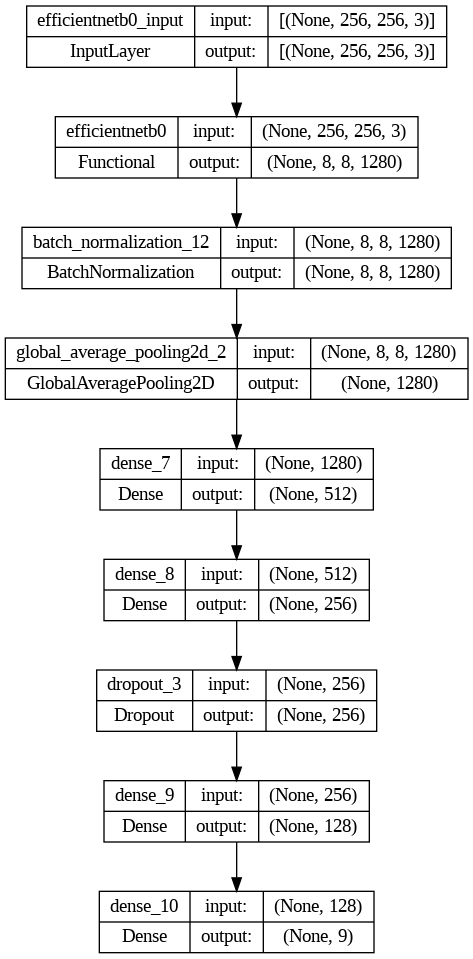

In [ ]:
from keras.models import Sequential
from keras.regularizers import l2

def make_model_transferEfficientNet(input_shape, num_classes):
    # get the base model (EfficientNet)
    base_model = keras.applications.EfficientNetB0(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False

    model = Sequential([
        data_augmentation_layer,
        base_model,
        layers.BatchNormalization(),
        layers.GlobalAveragePooling2D(),
        layers.Dense(1024, activation='relu'),
        #layers.Dense(256, activation='relu'),

        layers.Dropout(0.5),
        #layers.Dense(1024, activation='relu'),
        layers.Dense(units=num_classes, activation='softmax'),
        ])

    return model

# define the actual model
model_transferEfficientNet = make_model_transferEfficientNet(input_shape=img_size + (3,), num_classes=9)
# for testing
print("Model Input Shape: ", model_transferEfficientNet.input_shape)
print("Model Output Shape: ", model_transferEfficientNet.output_shape)

keras.utils.plot_model(model_transferEfficientNet, show_shapes=True)

#### Train EfficientNet model

In [ ]:
epochs = 50

checkpoint = keras.callbacks.ModelCheckpoint('EfficientNet-model-{val_accuracy:.3f}.hdf5', monitor='val_accuracy',
                                              verbose=1, save_best_only=True, mode='max')

callbacks = [checkpoint,]
model_transferEfficientNet.compile(
    optimizer = keras.optimizers.Adam(1e-3),
    loss = "sparse_categorical_crossentropy",
    metrics = ["accuracy"],
)

history_efficientNet = model_transferEfficientNet.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/50
2813/2813 [==============================] - ETA: 0s - loss: 0.5011 - accuracy: 0.8257
Epoch 1: val_accuracy improved from -inf to 0.88745, saving model to EfficientNet-model-0.887.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2813/2813 [==============================] - 167s 56ms/step - loss: 0.5011 - accuracy: 0.8257 - val_loss: 0.3262 - val_accuracy: 0.8874
Epoch 2/50
2812/2813 [============================>.] - ETA: 0s - loss: 0.3888 - accuracy: 0.8662
Epoch 2: val_accuracy improved from 0.88745 to 0.89034, saving model to EfficientNet-model-0.890.hdf5
2813/2813 [==============================] - 148s 53ms/step - loss: 0.3888 - accuracy: 0.8662 - val_loss: 0.3264 - val_accuracy: 0.8903
Epoch 3/50
2812/2813 [============================>.] - ETA: 0s - loss: 0.3476 - accuracy: 0.8811
Epoch 3: val_accuracy improved from 0.89034 to 0.90274, saving model to EfficientNet-model-0.903.hdf5
2813/2813 [==============================] - 147s 52ms/step - loss: 0.3476 - accuracy: 0.8811 - val_loss: 0.2832 - val_accuracy: 0.9027
Epoch 4/50
2812/2813 [============================>.] - ETA: 0s - loss: 0.3228 - accuracy: 0.8884
Epoch 4: val_accuracy improved from 0.90274 to 0.90504, saving model to EfficientNet-model-0.9

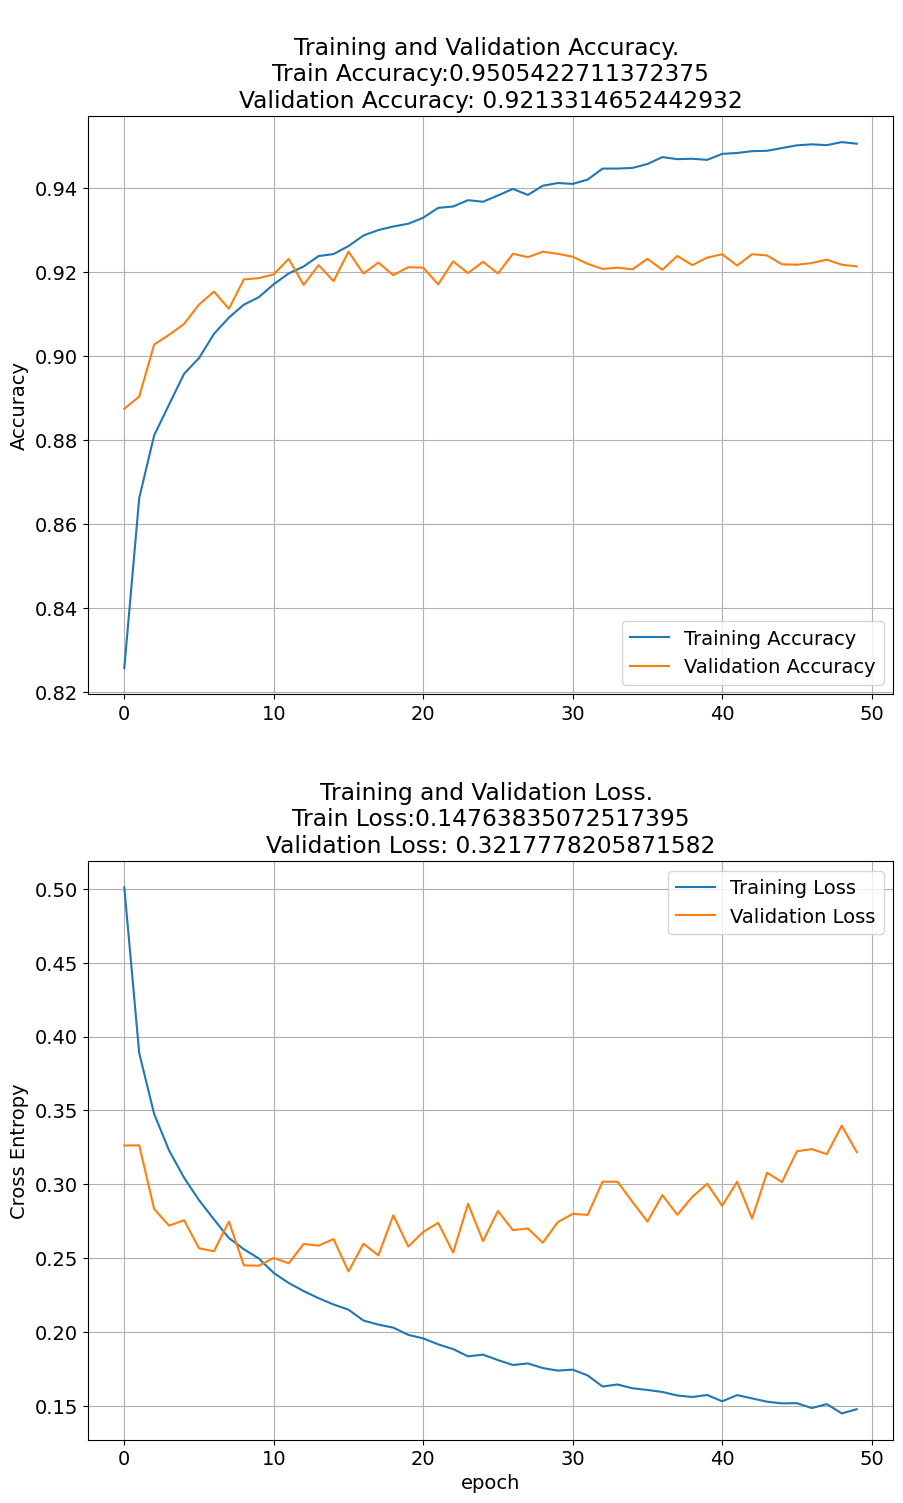

In [ ]:
# store results
acc = history_efficientNet.history['accuracy']
val_acc = history_efficientNet.history['val_accuracy']
loss = history_efficientNet.history['loss']
val_loss = history_efficientNet.history['val_loss']

# plot results
# accuracy
plt.figure(figsize=(10, 16))
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['font.size'] = 14
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.facecolor'] = 'white'
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title(f'\nTraining and Validation Accuracy. \nTrain Accuracy:{str(acc[-1])}\nValidation Accuracy: {str(val_acc[-1])}')

# loss
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title(f'Training and Validation Loss. \nTrain Loss:{str(loss[-1])}\nValidation Loss: {str(val_loss[-1])}')
plt.xlabel('epoch')
plt.tight_layout(pad=3.0)
plt.show()

In [ ]:
#load a model using model weights file
model_transferEfficientNet.load_weights("EfficientNet-model-0.925.hdf5")
'''
model_transferEfficientNet.compile(
    optimizer = keras.optimizers.Adam(learning_rate=1e-3),
    loss = "sparse_categorical_crossentropy",
    metrics = ["accuracy"],
)
'''

# evaluate model using the testing dataset
acc_score = model_transferEfficientNet.evaluate(val_ds)
print(acc_score)
print("Accuracy: {:.4f}%".format(acc_score[1] * 100))
print("Loss: ", acc_score[0])

225/225 [==============================] - 11s 47ms/step - loss: 0.4538 - accuracy: 0.8880
[0.4537885785102844, 0.8880223035812378]
Accuracy: 88.8022%
Loss:  0.4537885785102844


#### Transfer learning - Using XceptionNet

Model Input Shape:  (None, 256, 256, 3)
Model Output Shape:  (None, 9)


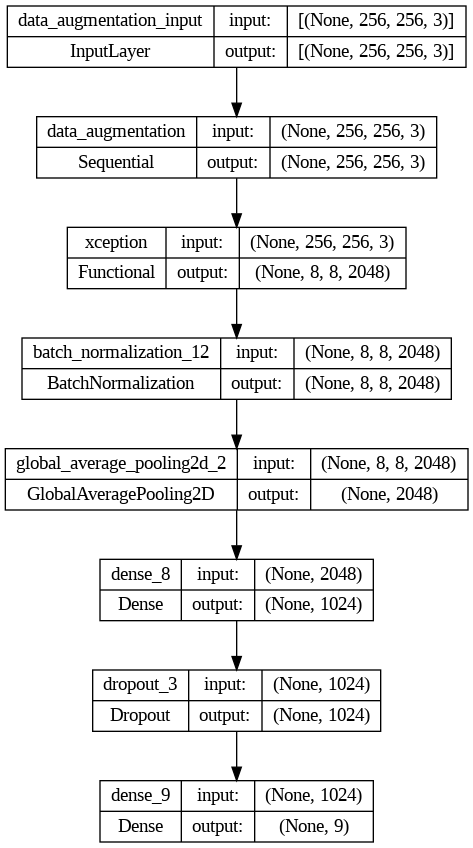

In [16]:
from keras.models import Sequential
from keras.regularizers import l2

def make_model_transferXceptionNet(input_shape, num_classes):
    # get the base model (XceptionNet)
    base_model = keras.applications.Xception(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False

    model = Sequential([
        data_augmentation_layer,
        base_model,
        layers.BatchNormalization(),
        layers.GlobalAveragePooling2D(),
        layers.Dense(1024, activation='relu'),
        #layers.Dense(256, activation='relu'),

        layers.Dropout(0.5),
        #layers.Dense(1024, activation='relu'),
        layers.Dense(units=num_classes, activation='softmax'),
        ])

    return model

# define the actual model
model_transferXceptionNet = make_model_transferXceptionNet(input_shape=img_size + (3,), num_classes=9)
# for testing
print("Model Input Shape: ", model_transferXceptionNet.input_shape)
print("Model Output Shape: ", model_transferXceptionNet.output_shape)

keras.utils.plot_model(model_transferXceptionNet, show_shapes=True)

#### Train XceptionNet

In [17]:
epochs = 50

checkpoint = keras.callbacks.ModelCheckpoint('XceptionNet-transfer-model-{val_accuracy:.3f}.hdf5', monitor='val_accuracy',
                                              verbose=1, save_best_only=True, mode='max')

callbacks = [checkpoint,]
model_transferXceptionNet.compile(
    optimizer = keras.optimizers.Adam(1e-3),
    loss = "sparse_categorical_crossentropy",
    metrics = ["accuracy"],
)

history_xceptionNet = model_transferXceptionNet.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/50
2813/2813 [==============================] - ETA: 0s - loss: 0.5549 - accuracy: 0.8219
Epoch 1: val_accuracy improved from -inf to 0.88545, saving model to XceptionNet-transfer-model-0.885.hdf5
2813/2813 [==============================] - 142s 49ms/step - loss: 0.5549 - accuracy: 0.8219 - val_loss: 0.3453 - val_accuracy: 0.8854
Epoch 2/50
2812/2813 [============================>.] - ETA: 0s - loss: 0.4253 - accuracy: 0.8574
Epoch 2: val_accuracy improved from 0.88545 to 0.89114, saving model to XceptionNet-transfer-model-0.891.hdf5
2813/2813 [==============================] - 137s 49ms/step - loss: 0.4252 - accuracy: 0.8574 - val_loss: 0.3285 - val_accuracy: 0.8911
Epoch 3/50
2813/2813 [==============================] - ETA: 0s - loss: 0.3882 - accuracy: 0.8696
Epoch 3: val_accuracy improved from 0.89114 to 0.89474, saving model to XceptionNet-transfer-model-0.895.hdf5
2813/2813 [==============================] - 137s 49ms/step - loss: 0.3882 - accuracy: 0.8696 - val_loss: 0

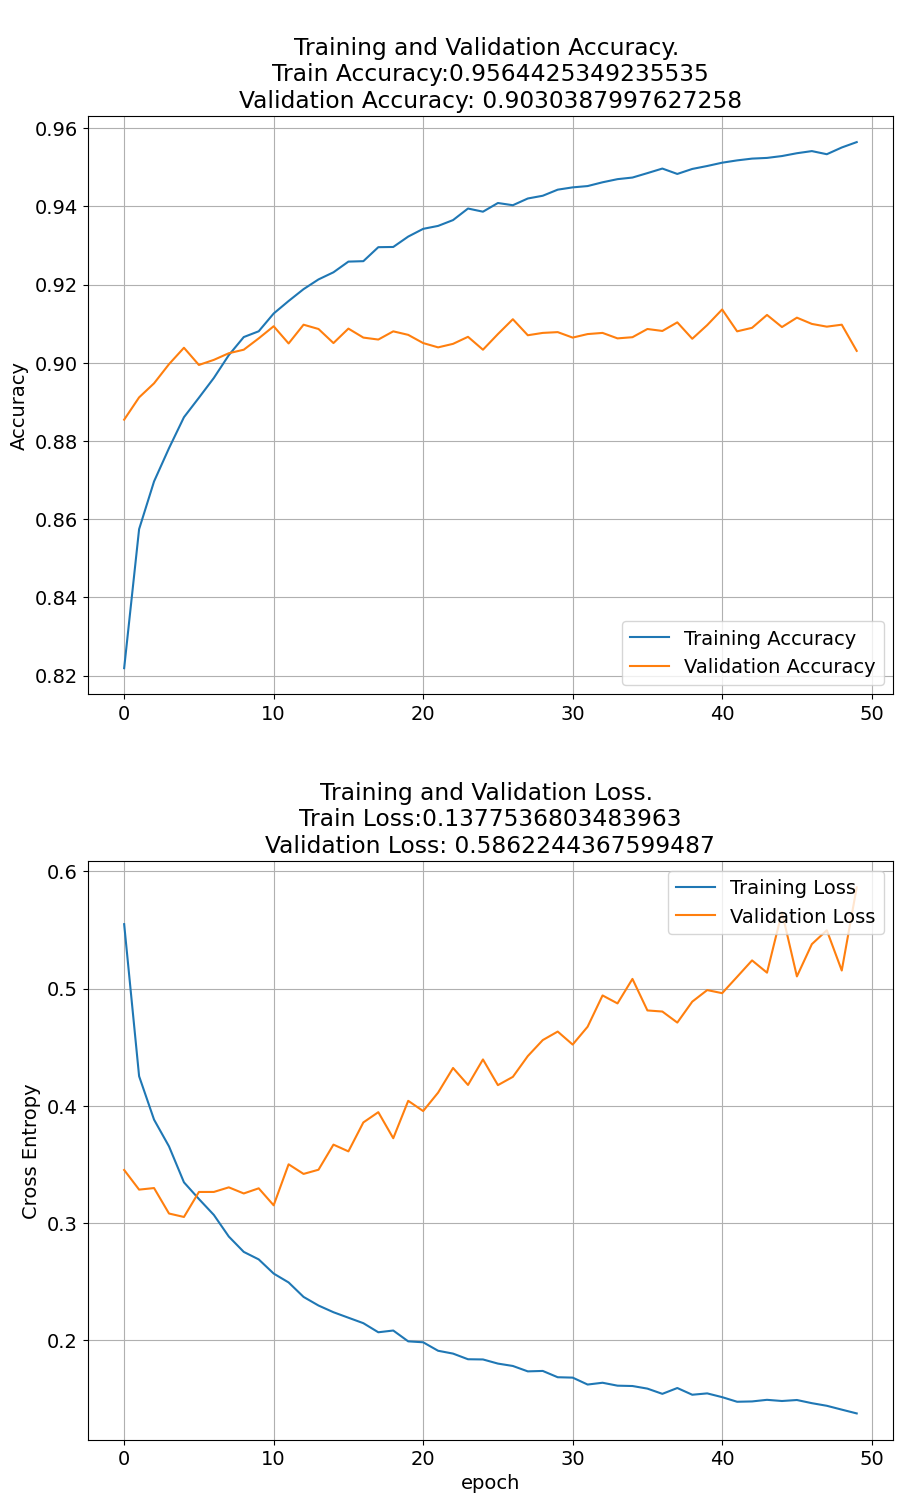

In [18]:
# store results
acc = history_xceptionNet.history['accuracy']
val_acc = history_xceptionNet.history['val_accuracy']
loss = history_xceptionNet.history['loss']
val_loss = history_xceptionNet.history['val_loss']

# plot results
# accuracy
plt.figure(figsize=(10, 16))
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['font.size'] = 14
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.facecolor'] = 'white'
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title(f'\nTraining and Validation Accuracy. \nTrain Accuracy:{str(acc[-1])}\nValidation Accuracy: {str(val_acc[-1])}')

# loss
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title(f'Training and Validation Loss. \nTrain Loss:{str(loss[-1])}\nValidation Loss: {str(val_loss[-1])}')
plt.xlabel('epoch')
plt.tight_layout(pad=3.0)
plt.show()

In [20]:
#load a model using model weights file
model_transferXceptionNet.load_weights("XceptionNet-transfer-model-0.914.hdf5")
'''
model_transferEfficientNet.compile(
    optimizer = keras.optimizers.Adam(learning_rate=1e-3),
    loss = "sparse_categorical_crossentropy",
    metrics = ["accuracy"],
)
'''

# evaluate model using the testing dataset
acc_score = model_transferXceptionNet.evaluate(test_ds)
print(acc_score)
print("Accuracy: {:.4f}%".format(acc_score[1] * 100))
print("Loss: ", acc_score[0])

225/225 [==============================] - 10s 43ms/step - loss: 1.0224 - accuracy: 0.8689
[1.022373914718628, 0.8689414858818054]
Accuracy: 86.8941%
Loss:  1.022373914718628
